# Predicting Diabetes

`Diabetes.csv` and is [from Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database). We have several questions - what information is more correlated with a positive diagnosis, and if we can only ask two questions to a patient, what should we ask and how would we give them a risk of being diagnosed.

This is a machine learning database, and normally we'd just extract features, feed to a ML algorithm and sit back and relax. But we'll get our hands dirty so that you can learn more.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df_original = pd.read_csv("data\Diabetes.csv")
df_original.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


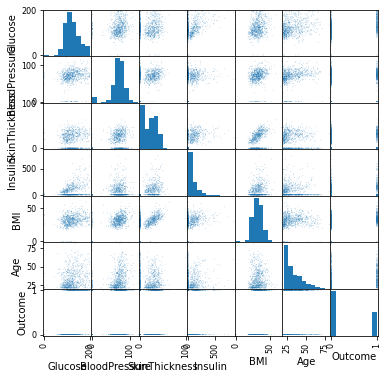

In [2]:
df = df_original.drop(["Pregnancies", "DiabetesPedigreeFunction"], axis=1)
pd.plotting.scatter_matrix(df, figsize=(6,6), s=2);

Let first answer the question: *What information is most correlated with diabetes?*

In [3]:
df.corr()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
Glucose,1.000000,0.152590,0.057328,0.331357,0.221071,0.263514,0.466581
BloodPressure,0.152590,1.000000,0.207371,0.088933,0.281805,0.239528,0.065068
SkinThickness,0.057328,0.207371,1.000000,0.436783,0.392573,-0.113970,0.074752
Insulin,0.331357,0.088933,0.436783,1.000000,0.197859,-0.042163,0.130548
BMI,0.221071,0.281805,0.392573,0.197859,1.000000,0.036242,0.292695
Age,0.263514,0.239528,-0.113970,-0.042163,0.036242,1.000000,0.238356
Outcome,0.466581,0.065068,0.074752,0.130548,0.292695,0.238356,1.000000


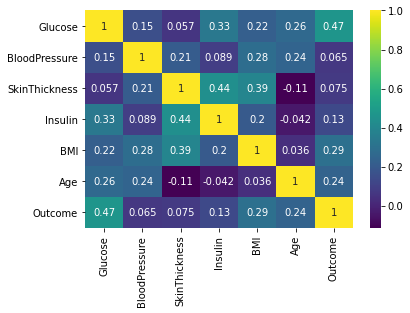

In [4]:
import seaborn as sb
sb.heatmap(df.corr(), annot=True, cmap="viridis");

From the correlations above, a naive approach might be to take the top correlated observables and drill down into them. In our case, its Glucose, BMI and Age.

In [5]:
df2 = df[["Glucose", "BMI", "Age", "Outcome"]]
df2.head()

,Glucose,BMI,Age,Outcome
0,148,33.6,50,1
1,85,26.6,31,0
2,183,23.3,32,1
3,89,28.1,21,0
4,137,43.1,33,1


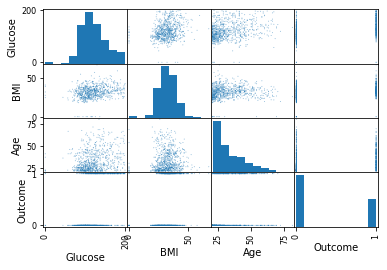

In [6]:
pd.plotting.scatter_matrix(df2, s=4);

Lucky we visualised this! Look at the histograms for Glucose and BMI - the spikes at zero are indicative that the dataset is using the value zero for when there is no data. Lets filter these out. And lets also drop age to keep this shorter.

In [7]:
df3 = df2.loc[(df2["Glucose"] > 1) & (df2["BMI"] > 1), ["Glucose", "BMI", "Outcome"]]
df3.head()

,Glucose,BMI,Outcome
0,148,33.6,1
1,85,26.6,0
2,183,23.3,1
3,89,28.1,0
4,137,43.1,1


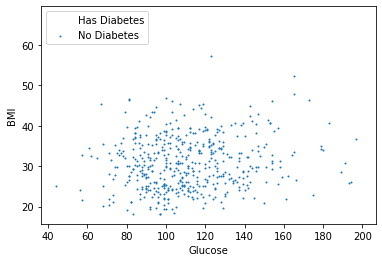

In [8]:
df_y = df3.loc[df3["Outcome"] == 1, ["Glucose", "BMI"]]
df_n = df3.loc[df3["Outcome"] == 0, ["Glucose", "BMI"]]

plt.scatter(df_y["Glucose"], df_y["BMI"], c="w", s=1, label="Has Diabetes")
plt.scatter(df_n["Glucose"], df_n["BMI"], s=1, label="No Diabetes")
plt.legend(loc=2)
plt.xlabel("Glucose")
plt.ylabel("BMI");

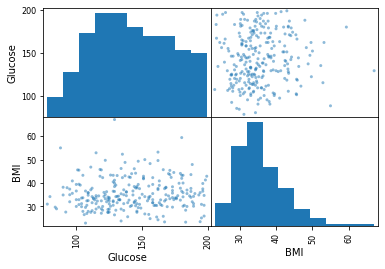

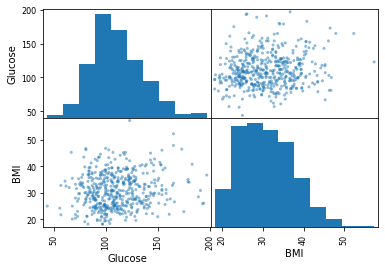

In [9]:
pd.plotting.scatter_matrix(df_y)
pd.plotting.scatter_matrix(df_n);

So its not perfect, but we can probably do an alright job approximating both these distributions as Gaussians.

Let's also add into the mix a test patient that comes in, with Glucose of 140 and BMI of 35. What is his chance of being diagnosed?

In [10]:
from scipy.stats import multivariate_normal as mn
prob_test = []
test_point = [140, 35]
x, y = np.meshgrid(np.linspace(50, 200, 20), np.linspace(10, 50, 20), indexing='ij')
points = np.dstack((x.flatten(), y.flatten()))

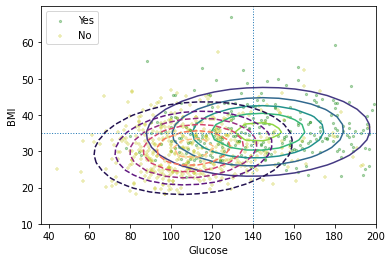

In [11]:
for d, l in zip([df_y, df_n], ["Yes", "No"]):
    is_yes = l == "Yes"
    mean = np.mean(d)
    cov = np.cov(d, rowvar=0)
    probs = mn.pdf(points, mean, cov).reshape(x.shape)
    prob_test.append(mn.pdf(test_point, mean, cov))
    plt.contour(x, y, probs, 
                cmap="viridis" if is_yes else "magma", 
                linestyles="-" if is_yes else "--")
    marker = "." if is_yes else "+"
    color = "g" if is_yes else "y"
    plt.scatter(d["Glucose"], d["BMI"], c=color, marker=marker, s=20, alpha=0.3, label=l)
plt.axvline(test_point[0], ls=":", lw=1)
plt.axhline(test_point[1], ls=":", lw=1)
plt.legend(loc=2)
plt.xlabel("Glucose")
plt.ylabel("BMI");

In [12]:
num_y = df_y.shape[0]
num_n = df_n.shape[0]

prob_diagnosis = num_y * prob_test[0] / (num_y * prob_test[0] + num_n * prob_test[1])
print(f"Positive diagnosis chance is {100 * prob_diagnosis:.2f}%")

Positive diagnosis chance is 49.95%


This might seem odd. Given the test patient is right on the maximum of our model for the diabetes patients, surely there should be a larger chance, right? Nope!

The reason is because - even though the distribution probability is higher, there are far more patients without diabetes than with. We can only directly compare the two distributions if they have equal probability all up (same number of people with and without). This is rarely the case, and so we have to weight them. In a Bayesian formalise, we are modifying our model prior.